In [1]:
# All needed libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau
import os

# Pre-procesamiento de keras
from keras.preprocessing.image import load_img 
import warnings 
from keras.preprocessing.image import img_to_array 
from keras.preprocessing.image import array_to_img 

Using TensorFlow backend.


# ChexRay: ResNet - Classifying Chest X-ray data to find pneumonia pxs
Created using data from Kaggle: https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

This dataset is poorly managed; to overcome this issue, all the data is loaded and re-arranged in order to obtain realistic results.

The data consist on images; these images are classified in two classes: `Normal` and `Pneumonia`. In this notebook, a ResNet Model is used to train and test over the above mentioned data. 

In [2]:
# Escalation factor managing function
def size_esc_factor(factor):
    return (round(1317*factor), round(1857*factor))
size = size_esc_factor(0.12)

flabels = ['PNEUMONIA','NORMAL'] # Folders

# Creating a function to import many images as a np array of 'objects'
def get_img_array(data_dir):
    data = []
    for label in flabels:
        path = os.path.join(data_dir, label)
        class_num = flabels.index(label)
        for img in os.listdir(path):
            img_arr = img_to_array(load_img(os.path.join(path, img), color_mode='grayscale', target_size=size, interpolation='nearest'))
            data.append([img_arr, class_num])
    return np.array(data)

We use the functions to obtain our np arrays

In [3]:
test = get_img_array('chest_xray\\test')
train = get_img_array('chest_xray\\train')
val = get_img_array('chest_xray\\val')

C:\Users\yng3d\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [4]:
test.shape, train.shape, val.shape

((624, 2), (5216, 2), (16, 2))

We re-arrange the arrays by merging them, creating new `train` and `val` arrays up next

In [5]:
train_val = np.append(train, val, axis=0)
train_val.shape

(5232, 2)

In [6]:
x_train_val = []
y_train_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train_val.append(feature)
    y_train_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [7]:
x_train_val = np.array(x_train_val) / 255
x_test = np.array(x_test) / 255

x_train_val.shape, x_test.shape

((5216, 158, 223, 1), (624, 158, 223, 1))

New train and val arrays:

In [8]:
x_train, x_val, y_train, y_val = train_test_split(x_train_val, y_train_val, test_size=0.12, random_state=24)

In [9]:
x_train.shape, x_val.shape

((4590, 158, 223, 1), (626, 158, 223, 1))

### How is data distributed?
This question has to be made, since as it can be seen below, in all datasets the `Normal` class is under-represented; this could cause overfitting during the training

C:\Users\yng3d\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

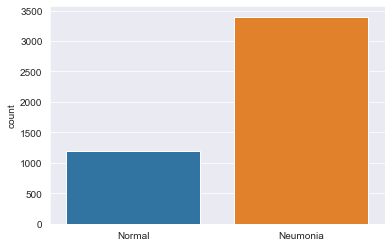

In [10]:
l = []
for i in y_train:
    if(i == 0):
        l.append("Neumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)

C:\Users\yng3d\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

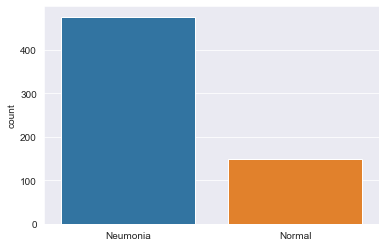

In [11]:
l = []
for i in y_val:
    if(i == 0):
        l.append("Neumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)      

C:\Users\yng3d\anaconda3\envs\tf-gpu\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

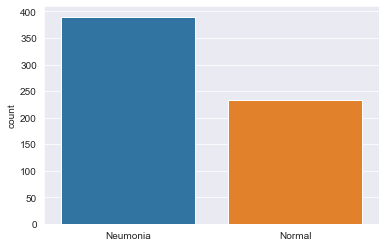

In [12]:
l = []
for i in y_test:
    if(i == 0):
        l.append("Neumonia")
    else:
        l.append("Normal")
sns.set_style('darkgrid')
sns.countplot(l)      

## Generador de imagenes

To solve the under-representation of the `Neumonia` class, a image generator is created in order to solve this issue.

In [13]:
datagen_train = ImageDataGenerator(
        featurewise_center=False,  # Establece media de 0 a las imágenes
        samplewise_center=False,  # Establece media de 0 a las imágenes a partir de una muestra
        featurewise_std_normalization=False,  # Divide los valores de las imagenes entre la STD
        samplewise_std_normalization=False,  # Divide los valores de las imagenes entre la STD de una muestra
        zca_whitening=False,  # Aplica blanqueado de ZCA (basado en PCA)
        #brightness_range = (0.95, 1.05), # Variación de brillo (intensidad) de las imágenes
        rotation_range = 15,  # Rota la imágen aleatoriamente de 0 a 15°
        zoom_range = 0.2, # Modifica el tamaño de la imágen
        width_shift_range=0.1,  # Modifica el encuadre de la imágen en el eje X
        height_shift_range=0.1,  # Modifica el encuadre de la imágen en el eje Y
        horizontal_flip = False,  # Rota las imágenes horizontalmente (Espejo horizontal)
        vertical_flip=False)  # Rota las imágenes verticalmente (Espejo vertical)

datagen_val = ImageDataGenerator(
        featurewise_center=False,  # Establece media de 0 a las imágenes
        samplewise_center=False,  # Establece media de 0 a las imágenes a partir de una muestra
        featurewise_std_normalization=False,  # Divide los valores de las imagenes entre la STD
        samplewise_std_normalization=False,  # Divide los valores de las imagenes entre la STD de una muestra
        zca_whitening=False,  # Aplica blanqueado de ZCA (basado en PCA)
        #brightness_range = (0.95, 1.05), # Variación de brillo (intensidad) de las imágenes
        rotation_range = 15,  # Rota la imágen aleatoriamente de 0 a 15°
        zoom_range = 0.2, # Modifica el tamaño de la imágen
        width_shift_range=0.1,  # Modifica el encuadre de la imágen en el eje X
        height_shift_range=0.1,  # Modifica el encuadre de la imágen en el eje Y
        horizontal_flip = False,  # Rota las imágenes horizontalmente (Espejo horizontal)
        vertical_flip=False)  # Rota las imágenes verticalmente (Espejo vertical)

datagen_train.fit(x_train)
datagen_val.fit(x_val)

# Creating the CNN ResNet Model

In [14]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, Add, AveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

def create_res_net():
    
    inputs = Input(shape=(158, 223, 1))
    num_filters = 64
    
    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=5,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    
    num_blocks_list = [1, 2, 1]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2
    
    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    t = Dropout(0.4)(t)
#     outputs = Dense(2, activation='softmax')(t)
    outputs = Dense(units = 1 , activation = 'sigmoid')(t)
    
    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [15]:
model = create_res_net()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 158, 223, 1) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 158, 223, 1)  4           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 158, 223, 64) 1664        batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 158, 223, 64) 0           conv2d[0][0]                     
______________________________________________________________________________________________

In [16]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [17]:
history = model.fit(datagen_train.flow(x_train,y_train, batch_size = 32), 
                    epochs = 30, 
                    validation_data = datagen_val.flow(x_val, y_val),
                    #batch_size = 1024,
                    callbacks = [learning_rate_reduction])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 144 steps, validate for 20 steps
Epoch 1/30
144/144 [==============================] - 89s 621ms/step - loss: 0.5639 - accuracy: 0.8621 - val_loss: 1.6240 - val_accuracy: 0.7636
Epoch 2/30
144/144 [==============================] - 79s 546ms/step - loss: 0.4308 - accuracy: 0.8908 - val_loss: 0.5603 - val_accuracy: 0.8578
Epoch 3/30
144/144 [==============================] - 95s 663ms/step - loss: 0.3853 - accuracy: 0.9046 - val_loss: 0.8319 - val_accuracy: 0.8147
Epoch 4/30
144/144 [==============================] - 89s 620ms/step - loss: 0.3597 - accuracy: 0.9035 - val_loss: 0.3584 - val_accuracy: 0.9233
Epoch 5/30
144/144 [==============================] - 90s 627ms/step - loss: 0.3284 - accuracy: 0.9115 - val_loss: 0.2221 - val_accuracy: 0.9281
Epoch 6/30
144/144 [==============================] - 91s 633ms/step - loss: 0.2766 - accuracy: 0.9139 - val_loss: 1.9313 - val_accuracy: 0.6422
Epoch 7/30
143/144 [=================

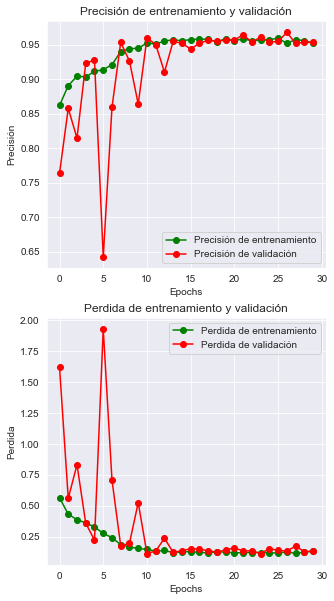

In [18]:
epochs = [i for i in range(30)]
fig , ax = plt.subplots(2,1)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(5,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Precisión de entrenamiento')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Precisión de validación')
ax[0].set_title('Precisión de entrenamiento y validación')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Precisión")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Perdida de entrenamiento')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Perdida de validación')
ax[1].set_title('Perdida de entrenamiento y validación')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Perdida")
plt.show()

Validation results show a good behaviour during the training phase, the same model is tested using the test dataset

In [19]:
predictions = model.predict(x_test)
pred = []
for i in predictions:
    if i < 0.5:
        pred_i = 0
    else:
        pred_i = 1
    pred.append(pred_i)

In [20]:
print(classification_report(y_test, pred, target_names = ['Neumonia (Class 0)','Normal (Class 1)']))

                    precision    recall  f1-score   support

Neumonia (Class 0)       0.88      0.95      0.92       390
  Normal (Class 1)       0.91      0.79      0.84       234

          accuracy                           0.89       624
         macro avg       0.90      0.87      0.88       624
      weighted avg       0.89      0.89      0.89       624



Results show a final accuracy of `0.89`.

### Model plot

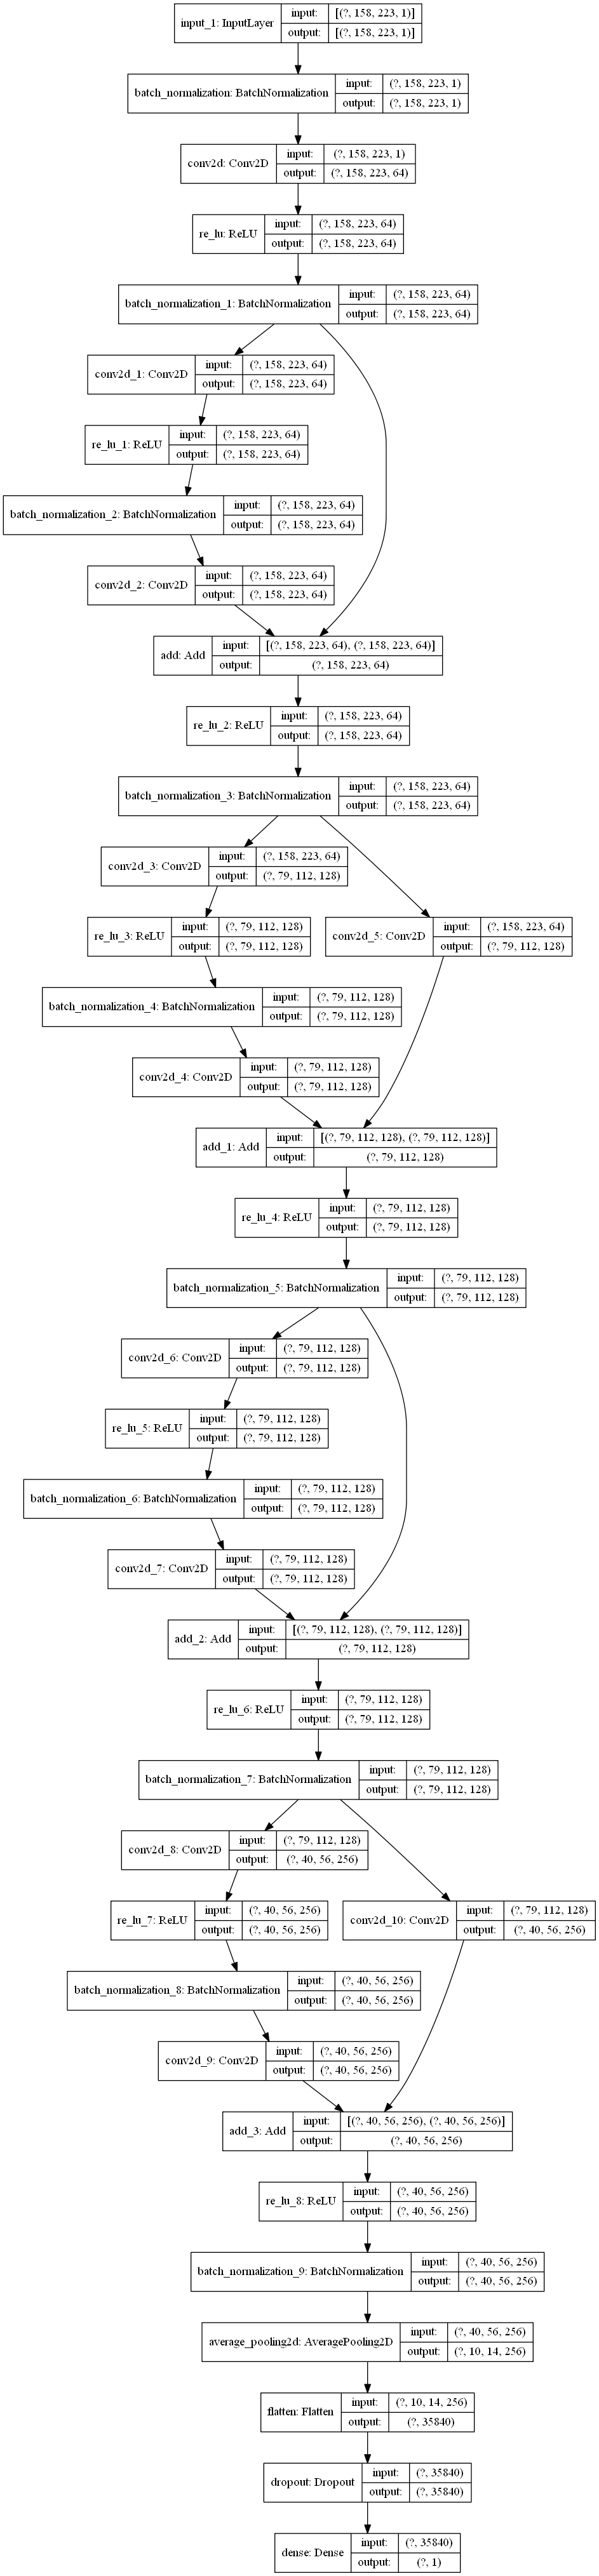

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot_ResNet.png', show_shapes=True, show_layer_names=True)